# Homework 4 - Group #24
## 1) Does basic house information reflect house's description?

Our goal is to implement two clustering and compare the results. We create two datasets and each of them will be filled by data that we scraped.

First of all, we import the following libraries.

In [256]:
import time # For time.sleep() method
import pandas as pd
import numpy as np
import requests 
from urllib.request import urlopen
from bs4 import BeautifulSoup

import nltk # To remove stopwords
from nltk.corpus import stopwords
import string # To remove punctuation
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer

import io
import json

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/robertapassarelli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Scraping
To create the dataset we have to scrape the website of [Immobiliare.it](https://www.immobiliare.it) using **Beautiful Soup** library.

In [2]:
print ("Start : %s" % time.ctime())
numb_pag = 410
df1 = pd.DataFrame(columns=['Price','Locali','Superficie','Bagni','Piano','Descrizione'] )
i = 1

while i <= numb_pag:
    url = "https://www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag="+str(i)
    html = urlopen(url)
    time.sleep(0.8) # to prevent the website block
    soup = BeautifulSoup(html, 'lxml')
    
    all_links = soup.find_all('a')
    
    links = []
    for link in all_links:
        if link.get('href')!= None:
            links.append(link.get("href")) # list with all links

    for item in links:
        if item[-4:] == 'html' and item[0:5] == 'https':
            site = urlopen(item)
            soup = BeautifulSoup(site, 'lxml')
            data = soup.find_all("ul", {'class': "list-inline list-piped features__list"})
            price = soup.find_all("ul", {'class':"list-inline features__price-block"})
            description = soup.find_all("div",{'class':"col-xs-12 description-text text-compressed"})
            try:
                pr = int(price[0].contents[0].get_text().replace("€","").replace('.',''))
                loc = data[0].contents[0].get_text().replace("\xa0","").replace("+", "").replace("locali", "").strip()
                mq = data[0].contents[1].get_text().replace("da ","").replace("\xa0m2","").replace("superficie","").replace("m2","").strip()
                bath = data[0].contents[2].get_text().replace("\xa0","").replace("+", "").replace("bagni", "").strip()
                floor = data[0].contents[3].get_text().replace("\xa0", "").replace("\n","").replace("piano","").replace("T","0").strip()
                # we replace the floor `T` (piano Terra) with the number zero
                descr = description[0].get_text()
                l = [pr, loc, mq, bath, floor, descr]
                # print(l)
                df = pd.DataFrame([l], columns=['Price','Locali','Superficie','Bagni','Piano','Descrizione'])
                df1 = pd.concat([df1, df], ignore_index = True) 
            except:
                pass
    i += 1
print ("End : %s" % time.ctime())

Start : Sat Dec  8 13:08:58 2018
End : Sat Dec  8 14:21:59 2018


We clean the data:
- replace `\n` character in the announcement's description with an empty space
- drop all the announcements that don't have an integer for the `floor`
- remove the point in the price 

In [3]:
df1 = df1[df1['Piano'].apply(lambda x: str(x).isdigit() )]
df1['Descrizione'] = df1['Descrizione'].str.replace(r'\n', ' ', regex=True)
df1['Price'] = df1['Price'].astype(str).str.strip()
df1['Price'] = df1['Price'].str.replace('.', '')
df2 = df1.values
index = list(range(len(df1)))
df1 = pd.DataFrame(df2, index = index, columns = ['Price','Locali','Superficie','Bagni','Piano','Descrizione'] )

Let's save the description in a `.txt` file.

In [4]:
description = list(df1.Descrizione)
with open('data/description.txt', 'w') as file:
     file.write(json.dumps(description))

#### 1) Information
The first matrix `matrix1` is $m_{ij} = value$, where $i \in \{announcement_1, ..., announcement_n\}$ ($n$ is the number of announcement) and $j \in \{price, locali, superficie, bagni, piano \}$.

In [195]:
matrix1 = df1[['Price', 'Locali', 'Superficie', 'Bagni', 'Piano']]
matrix1

,Price,Locali,Superficie,Bagni,Piano
0,225000,2,50,1,1
1,400000,3,60,1,3
2,500000,3,89,2,3
3,574000,4,89,2,5
4,300000,2,46,1,4
5,425000,3,72,2,4
6,669000,5,86,2,4
7,657000,5,87,2,5
8,257000,3,61,1,1
9,325000,2,60,1,3


#### 2) Description
The second matrix `matrix2` is $m_{ij} = \text{tfIdf}_{ij}$ where $i \in \{announcement_1, ..., announcement_n\}$ and $j \in \{word_1, ...,word_m\}$, with $n$ number of the announcements and $m$ is the cardinality of the vocabulary.

In [6]:
# open the `.txt` file with the descriptions
with open('data/description.txt')as f: 
    description = json.load(f)

We clean the descriptions:
- remove stopwords 
- remove punctuation
- stemming

Define a dictionary `clean_descr` with the structure:
- key: number of announcement
- value: cleaned word

In [198]:
stop_words = set(stopwords.words('italian')) # set of stopwords
stemmer = nltk.stem.snowball.ItalianStemmer() # italian stemmer
punctuation = set(string.punctuation) # set of punctuation

clean_descr = {}  

for i, row in df1[:].iterrows():
    # Turn the string in lowercase letter and remove the stopwords and non-alphabetic words
    newrow = row.Descrizione
    text = ([w.lower() for w in list(newrow.split(' ')) 
             if w.lower() not in stop_words and w.isalpha()])
    # To remove punctuation considering character by character
    l = []
    for word in text:
        word = ''.join(ch for ch in word if ch not in punctuation)
        l.append(word)
    # Stem the words and put in a dict
    clean_descr[i] = [stemmer.stem(w) for w in l]

Create`vocabulary` like a dictionary of the words contained in all the documents that maps each word to an integer, with the structure:
- key: word
- value: number

In [199]:
vocabulary = {} # vocabulary as a dictionary
i = 0

for idx in range(len(clean_descr)):
    for word in list(clean_descr.values())[idx]:
        if word not in vocabulary.keys():
            vocabulary[word] = i
            i += 1

In [200]:
with open('data/vocabulary.txt', 'w') as file:
     file.write(json.dumps(vocabulary))

Now we can easily proceed with the `inverted index`, a dictionary with:
- key: number that correspond to the value in the vocabulary
- value: number of announcement in which there is the word which corresponds to the key.

In [201]:
# inverted index 
inverted_d = {} # empty dict 

for key, value in clean_descr.items():
    for i in sorted(list(set(value))):
        if (vocabulary[i] in inverted_d):
            inverted_d[vocabulary[i]] = inverted_d[vocabulary[i]] + [key]
        else:
            inverted_d[vocabulary[i]] = [key]

In [202]:
with open('data/inverted_d.txt', 'w') as file:
     file.write(json.dumps(inverted_d))

We need to calculate the **TF-IDF** of all the words, that is defined as the "term frequency" times the "inverse document frequency" where:
- "term frequency" is the ratio between the number of the term occurencies in the announcement and the total number of words in the announcement;
- "inverse document frequency" is the logarithm of the ratio between the total number of announcements and the number of announcements containing the term (plus 1 to avoid division by zero).

IDF is indipendent from the specific announcement, thus we can calculate it once and use it when we need it. Each term will have a single IDF.

In [203]:
idf = {}
n_ann = len(clean_descr)

for term_id, ann in inverted_d.items():
    idf[term_id] = pd.np.log(n_ann/(1+len(ann)))
    
# inverted index 
tfidf_inverted_a = {} # empty dict 

for key, value in clean_descr.items():
    for i in sorted(list(set(value))):
        if (vocabulary[i] in tfidf_inverted_a):
            tfidf_inverted_a[vocabulary[i]] = tfidf_inverted_a[vocabulary[i]] + [(key, (value.count(i)/len(value)) * idf[vocabulary[i]])]
        else:
            tfidf_inverted_a[vocabulary[i]] = [(key, (value.count(i)/len(value)) * idf[vocabulary[i]])]


In [13]:
with open('data/tfidf_inverted_a.txt', 'w') as file:
     file.write(json.dumps(tfidf_inverted_a))

In [204]:
matrix = []

for word in tfidf_inverted_a.keys():
    rows = []
    indexis = list(map(lambda x:x[0],tfidf_inverted_a[word]))
    for j in range(len(df1)):
        if j in indexis:
            idx = indexis.index(j)
            rows.append(tfidf_inverted_a[word][idx][1])
        else:
            rows.append(0)
    matrix.append(rows)    

In [205]:
l = list(tfidf_inverted_a.values())
words = list(vocabulary.keys())

words_ordered = []
for i in words:
    words_ordered.append(i)

rows = set()
for i in range(len(l)):
    for j in range(len(l[i])):
        rows.add(l[i][j][0])

In [206]:
descr_matrix = pd.DataFrame(matrix, index = words_ordered, columns = rows)
descr_matrix = descr_matrix.transpose()

In [207]:
descr_matrix

,papill,eur,eleg,compless,residenzial,rifinitissim,bilocal,compost,soggiorn,angol,...,lauretan,penalizz,atti,consistt,ascan,spinacet,barrier,rugger,bacon,balestr
0,0.009283,0.027691,0.174033,0.043179,0.015780,0.020895,0.045488,0.059375,0.012007,0.016086,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.005455,0.016272,0.000000,0.000000,0.009273,0.012278,0.000000,0.000000,0.007056,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.005570,0.016614,0.000000,0.000000,0.009468,0.012537,0.000000,0.000000,0.007204,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.009994,0.000000,0.000000,0.000000,0.007605,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.005629,0.016791,0.000000,0.000000,0.009569,0.012670,0.000000,0.000000,0.000000,0.009754,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.016972,0.000000,0.000000,0.009672,0.012806,0.000000,0.000000,0.007359,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.009672,0.012806,0.000000,0.000000,0.007359,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.009672,0.012806,0.000000,0.000000,0.007359,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005557,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.017156,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009966,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Clustering
This step consists in clustering the house announcements using *K-means++*. To choose the optimal number of clusters, we use the **Elbow-Method**.

In [208]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

First we try with the information matrix.

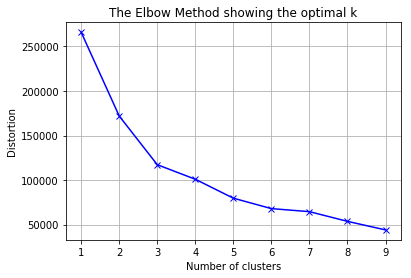

In [209]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(matrix1)
    kmeanModel.fit(matrix1)
    distortions.append(sum(np.min(cdist(matrix1, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / matrix1.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

From our scatterplot we can see that the optimal $k$ is $3$, because from that point on, if we add a $k$, it does not cause an evident difference.

In [210]:
kmeans1 = KMeans(n_clusters=3)

# Fitting the input data
kmeans1 = kmeans1.fit(matrix1)
labels1 = kmeans1.labels_

In [446]:
A = set() # empty set 
B = set()
C = set()
for i in range(len(matrix1)):
    if labels1[i] == 0:
        A.add(i)
    elif labels1[i] == 1:
        B.add(i)
    elif labels1[i] == 2:
        C.add(i)

Then we see with the description matrix.

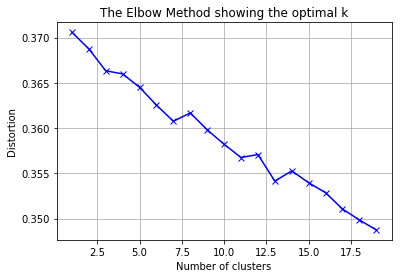

In [213]:
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(descr_matrix)
    kmeanModel.fit(descr_matrix)
    distortions.append(sum(np.min(cdist(descr_matrix, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / descr_matrix.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [246]:
kmeans2 = KMeans(n_clusters=3)
# Fitting the input data
kmeans2 = kmeans2.fit(descr_matrix)
labels2 = kmeans2.labels_

In [447]:
A1 = set()
B1 = set()
C1 = set()
for i in range(len(descr_matrix)):
    if labels2[i] == 0:
        A1.add(i)
    elif labels2[i] == 1:
        B1.add(i)
    elif labels2[i] == 2:
        C1.add(i)

### Comparison among cluster
We expect that both datasets will lead to similar clusters. Is this true?
#### Find similar clusters
To check this, use the **Jaccard-Similarity** to measure the similarity betweeen the two outputs (information clusters vs description clusters). The Jaccard-Similarity is a statistic coefficient used for comparing the similarity and diversity of sample set. It is defined as the size of the intersection divided by the size of the union of the sample sets: $J(A,B) = \frac{|A \cap B|}{|A \cup B|}.$

Our goal is return the 3-most similar couples of clusters.

In [429]:
def jaccard_similarity(S1, S2):
    js = len(S1.intersection(S2))/len(S1.union(S2))
    return js

In [461]:
set_1 = [A, B, C]
set_2 = [A1, B1, C1]
n_set_1 = ['A', 'B', 'C']
n_set_2 = ['A1', 'B1', 'C1']

In [462]:
js = []
jsd = {}
jsd_name = {}
for i in range(len(set_1)):
    for j in range(len(set_2)):
        c = jaccard_similarity(set_1[i], set_2[j])
        js.append(c)
        jsd[c] = [set_1[i], set_2[j]]
        jsd_name[c] = [n_set_1[i], n_set_2[j]]

In [463]:
l = []
for i in range(3):
    m = max(js)
    l.append(m)
    js.remove(m)

for i in l:
    print(jsd_name[i]) # 3-most similar couples of clusters

['B', 'B1']
['C', 'B1']
['A', 'B1']


In [464]:
df_js = pd.DataFrame(columns=['Jac_similarity','Clusters','Announcements'] )
for i in range(len(set_1)):
    for j in range(len(set_2)):
        jac_similarity = jaccard_similarity(set_1[i], set_2[j])
        lab = [n_set_1[i], n_set_2[j]]
        announc = set_1[i].union(set_2[j])
        lst = [jac_similarity, lab, announc]   

        df = pd.DataFrame([lst], columns=['Jac_similarity','Clusters','Announcements'])
        df_js = pd.concat([df_js, df], ignore_index = True)

In [465]:
df_js

,Jac_similarity,Clusters,Announcements
0,0.000000,"[A, A1]","{259, 1542, 774, 267, 270, 1040, 1556, 21, 104..."
1,0.054819,"[A, B1]","{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,0.000000,"[A, C1]","{259, 1542, 774, 267, 270, 1556, 21, 281, 29, ..."
3,0.027273,"[B, A1]","{0, 1, 2, 4, 5, 8, 9, 11, 12, 13, 14, 15, 16, ..."
4,0.679157,"[B, B1]","{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
5,0.012407,"[B, C1]","{0, 1, 2, 4, 5, 8, 9, 11, 12, 13, 14, 15, 16, ..."
6,0.004494,"[C, A1]","{3, 6, 7, 1032, 10, 1034, 1037, 1040, 17, 18, ..."
7,0.245941,"[C, B1]","{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
8,0.002342,"[C, C1]","{3, 6, 7, 1032, 10, 1034, 1037, 17, 18, 19, 20..."


## Word cloud of house descriptions
We create a *wordcloud* for each couple of clusters. The words that will be represented are those extracted from the description of the houses that are in the relative couple.

In [482]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
from PIL import Image
from os import path
stopwords = set(stopwords.words('italian'))

### Wordcloud 

We want to take the descriptions of all the announcement in the clusters.

In [480]:
def create_wordcloud(text, stopwords): 
    d = getcwd()
    
    mask = np.array(Image.open(path.join(d, "cloud.png")))
    wc = WordCloud(background_color="white", mask=mask, 
                   stopwords=stopwords, relative_scaling = 1.0, max_font_size=90)
    wc.generate(text)

    plt.figure(figsize=(20,20))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [476]:
text = ''
txt = []
for i in range(len(df_js)):
    for j in df_js.iloc[i].Announcements:
        text = text + df1.iloc[j].Descrizione
    txt.append(text)

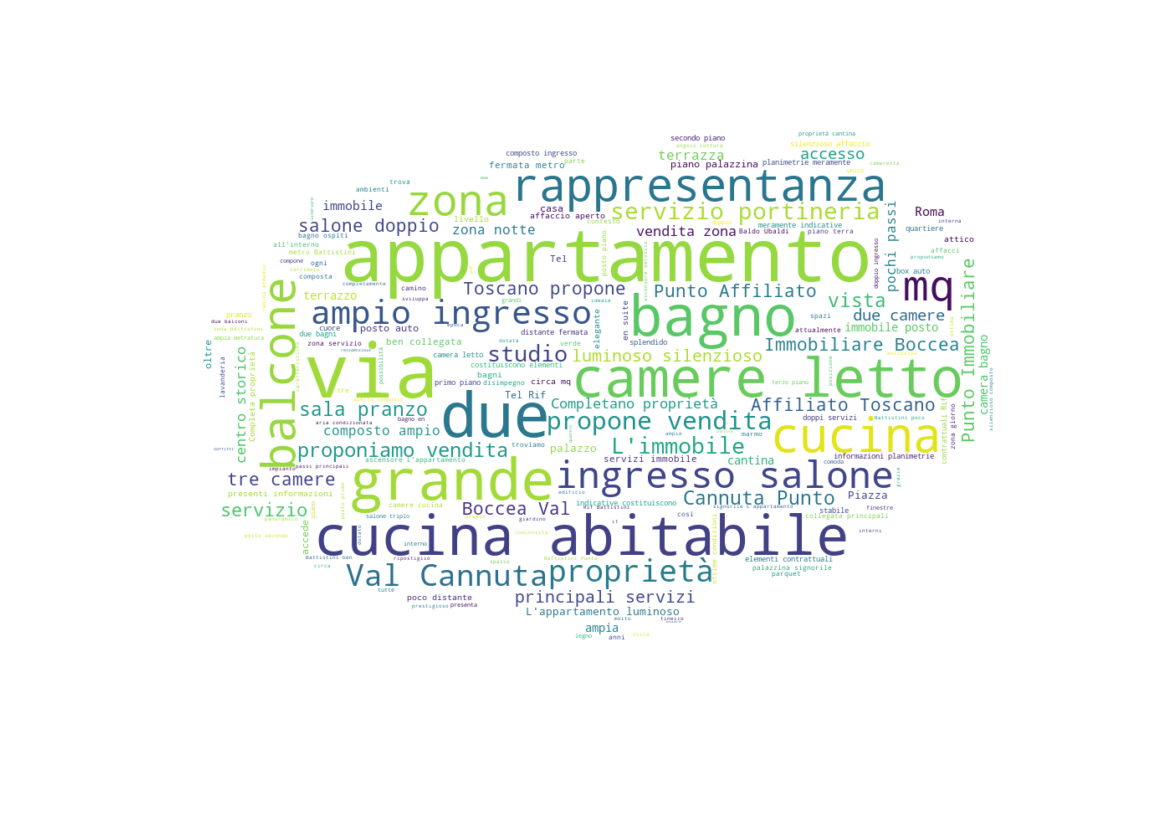

In [483]:
text = txt[0]
create_wordcloud(text, stopwords)

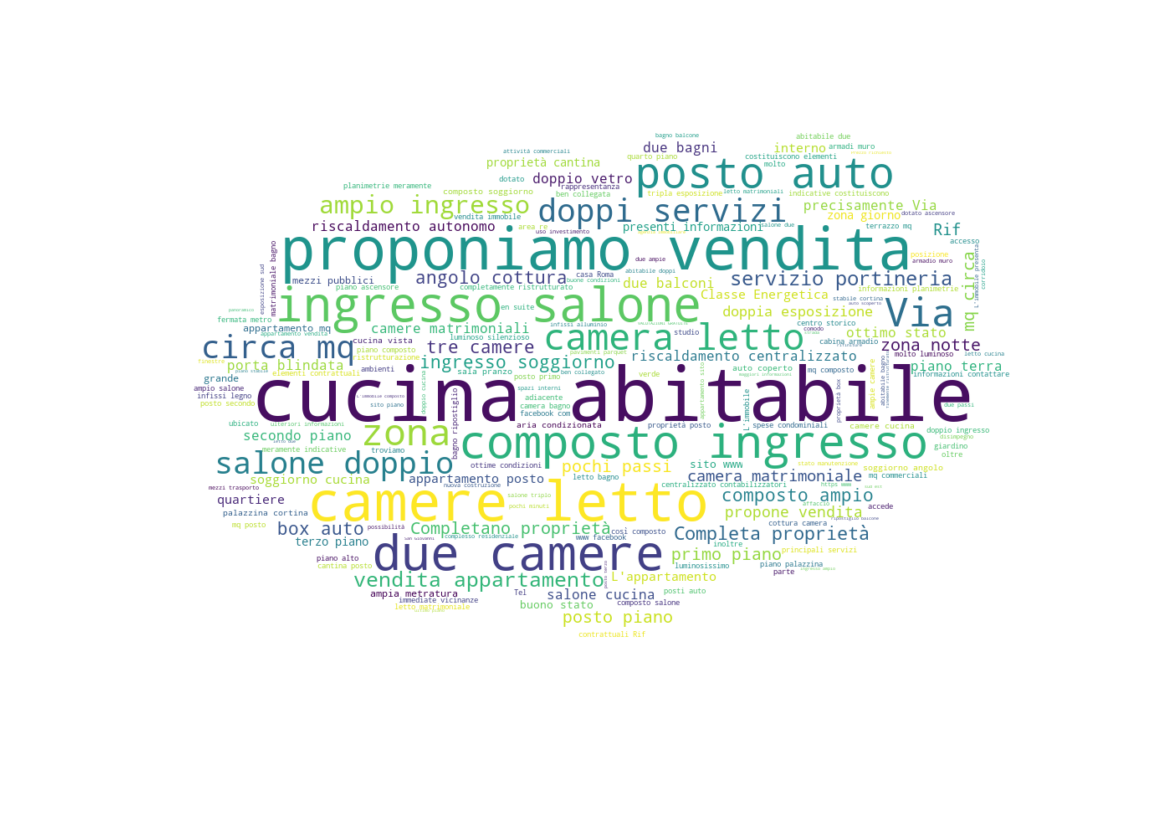

In [484]:
text = txt[1]
create_wordcloud(text, stopwords)

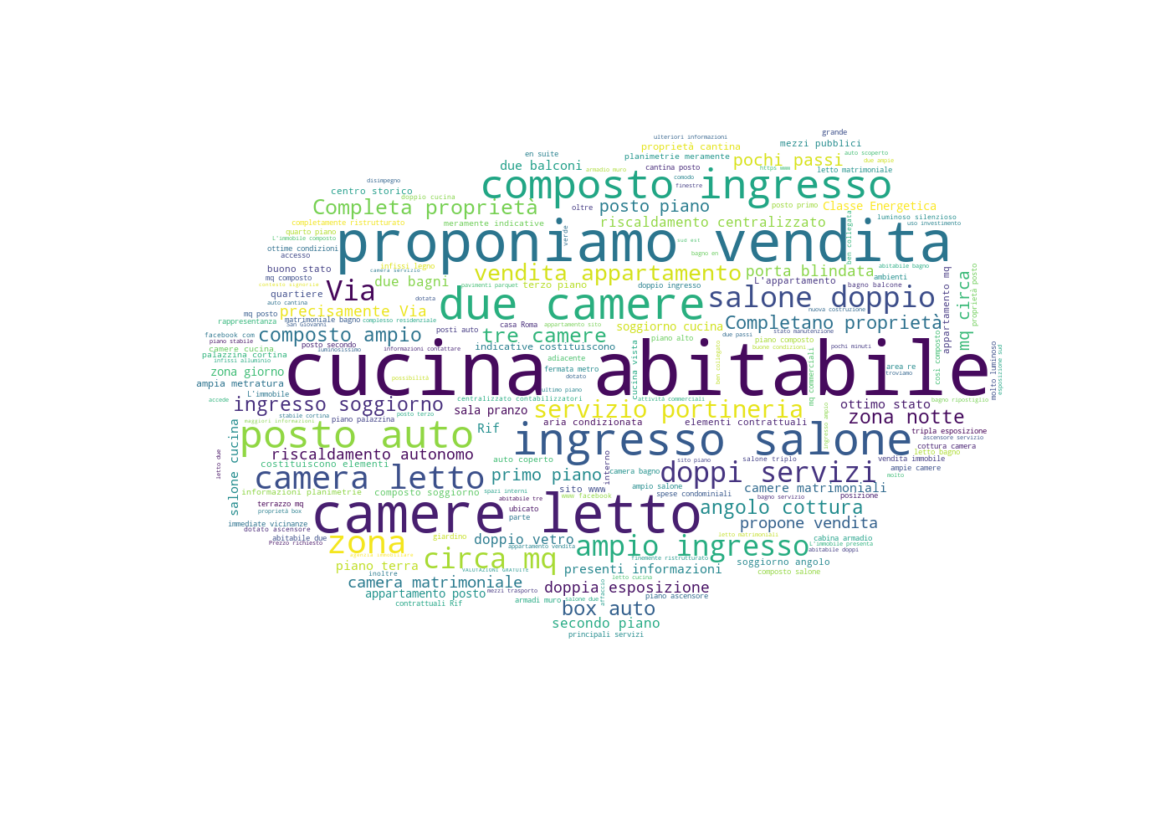

In [486]:
text = txt[2]
create_wordcloud(text, stopwords)